In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


2022-09-29 15:47:46.937519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import collections
import sys

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score, precision_recall_curve, auc, confusion_matrix,accuracy_score, plot_confusion_matrix, PrecisionRecallDisplay 
from sklearn.model_selection import train_test_split

import seaborn as sns

from tqdm import tqdm

import helper_functions
pd.options.display.max_columns = None

In [3]:
filename = '../data/preprocessed_data.pickle'
figure_path = '../report/figures/baseline/'

input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [4]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [5]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [6]:
input_dim = x_train.shape[1]

batch_size = 512
max_epochs = 50

In [7]:
x_train

array([[1.2207218e-03, 3.9295829e-04, 9.1009197e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.8899825e-01, 1.3333332e-07, 4.5504598e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.2742047e-01, 7.9999995e-07, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.2207218e-03, 8.1188965e-01, 2.7302760e-05, ..., 0.0000000e+00,
        8.1166667e-01, 8.1166667e-01],
       [8.0872816e-04, 8.4505824e-04, 4.5504598e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.2207218e-03, 1.2213415e-03, 9.1009197e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [8]:
def make_labels_binary(label_encoder, labels):
    normal_data_index = np.where(label_encoder.classes_ == 'BENIGN')[0][0]
    new_labels = labels.copy()
    new_labels[labels != normal_data_index] = 1
    new_labels[labels == normal_data_index] = 0
    return new_labels

In [9]:
y_train = make_labels_binary(le, y_train)
y_test = make_labels_binary(le, y_test)

In [10]:
len(np.where(y_train==1)[0])

417173

In [11]:
len(np.where(y_train==0)[0])

1703734

In [12]:
len(np.where(y_train==0)[0]) / (len(np.where(y_train==1)[0]) + len(np.where(y_train==0)[0]))

0.8033044353194176

In [13]:
model = Sequential()
model.add(Dense(64, input_shape=(x_train.shape[1],), activation='relu', kernel_initializer=initializers.glorot_normal(seed=42)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer=initializers.glorot_normal(seed=42)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer=initializers.glorot_normal(seed=42)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initializers.glorot_normal(seed=42)))
model.summary()

weights = class_weight={0: 0.05, 1: 0.95}
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max',
                                   patience=10,
                                   restore_best_weights=True)

history = model.fit(x_train,
                    y_train,
                    callbacks=[es],
                    epochs=max_epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    shuffle=False,
                    class_weight=weights,
                    verbose=1)

2022-09-29 15:47:51.643456: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-29 15:47:51.647121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-29 15:47:51.678896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 15:47:51.679091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2022-09-29 15:47:51.679104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-29 15:47:51.694564: I tensorflow/stream_executor/platfo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                5056      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

2022-09-29 15:47:52.651272: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 595550592 exceeds 10% of free system memory.
2022-09-29 15:47:52.867621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-29 15:47:52.883054: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3601430000 Hz


Epoch 1/50


2022-09-29 15:47:53.187911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


3729/3729 [==============================] - 8s 2ms/step - loss: 0.0267 - accuracy: 0.8396 - val_loss: 0.1407 - val_accuracy: 0.9481
Epoch 2/50
3729/3729 [==============================] - 7s 2ms/step - loss: 0.0107 - accuracy: 0.9536 - val_loss: 0.0926 - val_accuracy: 0.9682
Epoch 3/50
3729/3729 [==============================] - 7s 2ms/step - loss: 0.0096 - accuracy: 0.9583 - val_loss: 0.1167 - val_accuracy: 0.9614
Epoch 4/50
3729/3729 [==============================] - 7s 2ms/step - loss: 0.0090 - accuracy: 0.9613 - val_loss: 0.0906 - val_accuracy: 0.9673
Epoch 5/50
3729/3729 [==============================] - 7s 2ms/step - loss: 0.0086 - accuracy: 0.9629 - val_loss: 0.0777 - val_accuracy: 0.9699
Epoch 6/50
3729/3729 [==============================] - 7s 2ms/step - loss: 0.0082 - accuracy: 0.9642 - val_loss: 0.0855 - val_accuracy: 0.9683
Epoch 7/50
3729/3729 [==============================] - 7s 2ms/step - loss: 0.0080 - accuracy: 0.9650 - val_loss: 0.1011 - val_accuracy: 0.9632
Epo

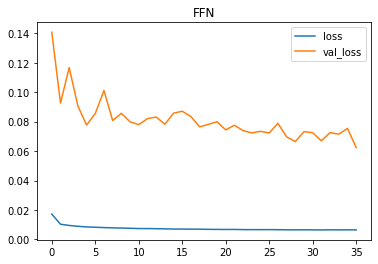

In [14]:
helper_functions.plot_loss(history, figure_path + 'loss_baseline.png', 'FFN')

In [15]:
history.history['accuracy']

[0.9089650511741638,
 0.9555153846740723,
 0.9592490792274475,
 0.9618176817893982,
 0.963333785533905,
 0.9640646576881409,
 0.9652119278907776,
 0.9655922651290894,
 0.9659574031829834,
 0.9667348861694336,
 0.9675804376602173,
 0.9678449630737305,
 0.9686512351036072,
 0.9693852066993713,
 0.9699064493179321,
 0.9704062342643738,
 0.9705089330673218,
 0.9700751900672913,
 0.9711287021636963,
 0.9710506200790405,
 0.9712214469909668,
 0.971246600151062,
 0.9716416001319885,
 0.9716944694519043,
 0.9720627665519714,
 0.9719899892807007,
 0.9722011089324951,
 0.9722393155097961,
 0.9726113080978394,
 0.9720612168312073,
 0.9724137783050537,
 0.9729926586151123,
 0.9724572896957397,
 0.9728014469146729,
 0.972764253616333,
 0.9726448059082031]

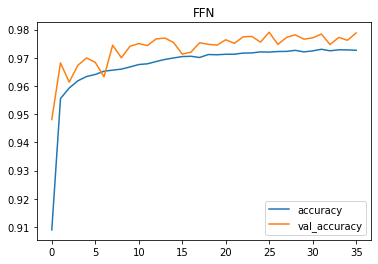

In [16]:
helper_functions.plot_accuracy(history, figure_path + 'accuracy_baseline.png', 'FFN')

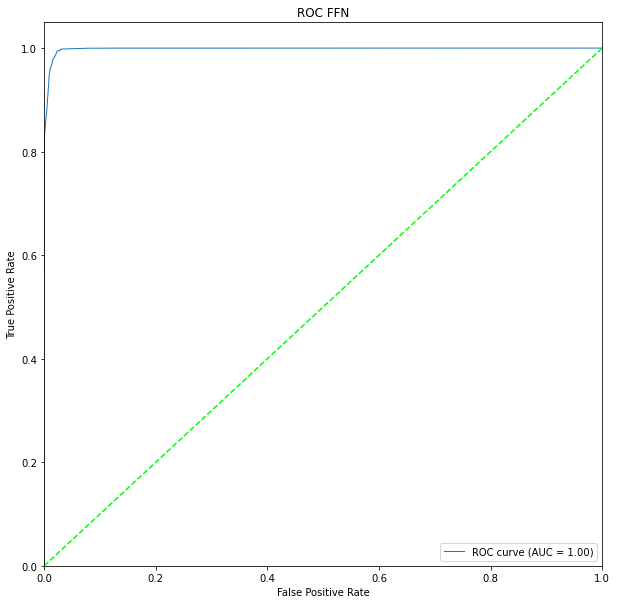

In [17]:
preds_test = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)

helper_functions.plot_roc(tpr, fpr, roc_auc, figure_path + 'roc_baseline.png', 'FFN')

In [18]:
precision_recall_curve

<function sklearn.metrics._ranking.precision_recall_curve(y_true, probas_pred, *, pos_label=None, sample_weight=None)>

In [19]:
threshold_idx = np.argmax(tpr - fpr)
threshold = thresholds[threshold_idx]
print(threshold)

0.6039149


In [20]:
pred_labels = (preds_test > threshold).astype(int)

results = confusion_matrix(y_test, pred_labels)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, pred_labels, average='binary')
print('Accuracy Score :', accuracy_score(y_test, pred_labels))
print('Precision :', precision)
print('Recall :', recall)
print('F1 :', f1)

Accuracy Score : 0.9803046526792547
Precision : 0.9133113267840789
Recall : 0.994497176843661
F1 : 0.9521768399071288


Accuracy Score : 0.8876188347721046
Precision : 0.6500718646240754
Recall : 0.9312972170207271
F1 : 0.7656784559847108

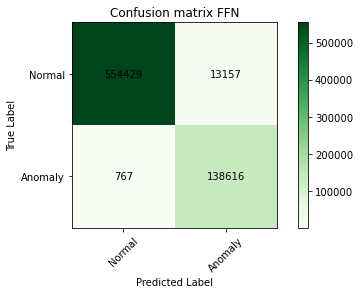

In [21]:
helper_functions.plot_confusion_matrix(results, figure_path + 'confusion_baseline.png', 'FFN')